In [1]:
# load train.csv and test.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("data/train.csv")

In [2]:
X = df.drop(['loan_status', 'id'], axis=1)
y = df['loan_status']

In [3]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


In [4]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_grade']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length' ]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def create_preprocessing_pipeline(categorical_features, numerical_features):
    # Numerical pipeline
    num_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline
    cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # Combine pipelines
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

    return preprocessor

# Define your features

# Create the preprocessing pipeline
preprocessor = create_preprocessing_pipeline(categorical_features, numerical_features)

# Create the full pipeline including XGBoost
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Use the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
full_pipeline.fit(X_train, y_train)

# calculate ROC AUC score
print(f'Train score: {roc_auc_score(y_train, full_pipeline.predict_proba(X_train)[:, 1])}')
print(f'Test score: {roc_auc_score(y_test, full_pipeline.predict_proba(X_test)[:, 1])}')

Train score: 0.9874585370147979
Test score: 0.9547410730058964


In [7]:
from sklearn.utils import estimator_html_repr
from IPython.display import display, HTML

# Assuming you've already created your full_pipeline as shown in the previous responses

# Generate the HTML representation
pipeline_html = estimator_html_repr(full_pipeline)

# Display the HTML
display(HTML(pipeline_html))

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np

# Assume X and y are your features and target variables

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Set up stratified k-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
for name, model in models.items():
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    
    print(f"{name} - Mean accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    
# The model with the highest mean accuracy is considered the best

Random Forest - Mean accuracy: 0.9504 (+/- 0.0025)
SVM - Mean accuracy: 0.9433 (+/- 0.0023)
Logistic Regression - Mean accuracy: 0.9121 (+/- 0.0024)


In [16]:
best_model = models['Random Forest']

# Debugging

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of the trees
    min_samples_split=5,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider when looking for the best split
    bootstrap=True,            # Use bootstrap samples when building trees
    random_state=42            # For reproducibility
)

pipe_best = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_classifier)
])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_best, X=X, y=y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [28]:
print('Train mean:', train_mean)
print('Train std:', train_std)
print('Test mean:', test_mean)
print('Test std:', test_std)

Train mean: [0.95718075 0.95280409 0.95089049 0.95164362 0.95118227 0.95089996
 0.95111514 0.95175256 0.95167151 0.95143615]
Train std: [0.00113679 0.00034104 0.00034034 0.00065887 0.00065437 0.00048602
 0.00085339 0.00038082 0.0003219  0.00040519]
Test mean: [0.93823858 0.94289376 0.94369513 0.94563911 0.94551965 0.94592894
 0.94645754 0.9465428  0.94696908 0.94693498]
Test std: [0.00239615 0.00199423 0.00179238 0.00260403 0.00171766 0.00212236
 0.00194601 0.00220827 0.0017163  0.00236298]


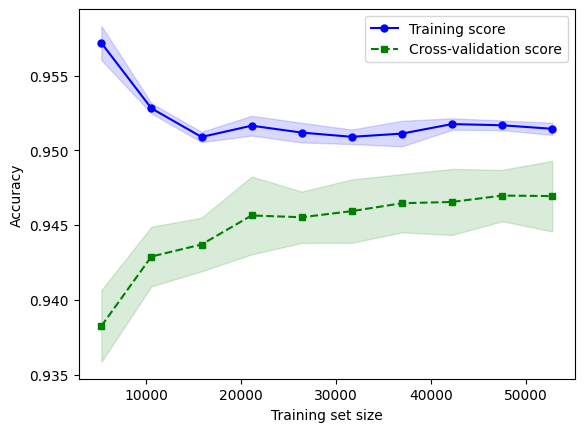

In [30]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [8]:
from sklearn.model_selection import validation_curve

def benchmark(Model, param_name, param_range):
    train_scores, test_scores = validation_curve(
        estimator=Pipeline([
            ('preprocessor', preprocessor),
            ('model', Model())
        ]),
        X=X,
        y=y,
        param_name=f"model__{param_name}",
        param_range=param_range,
        cv=10,
        scoring="accuracy",
        n_jobs=-1
    )

    # Calculate mean and standard deviation for training scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.xlabel('Tree depth')
    plt.ylabel(param_name)
    plt.legend(loc='best')
    plt.show()

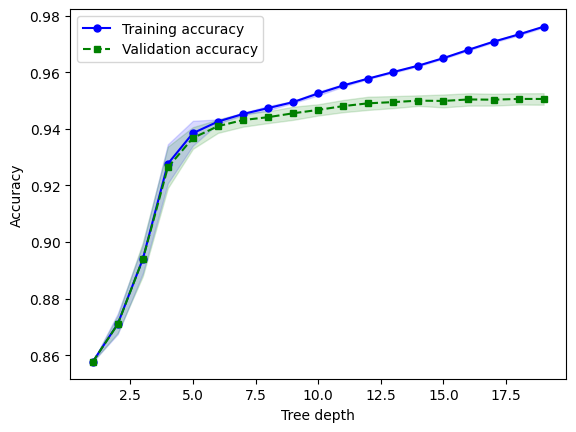

In [40]:
benchmark(RandomForestClassifier, 'max_depth', np.arange(1, 10, 1))

max_depth = 5

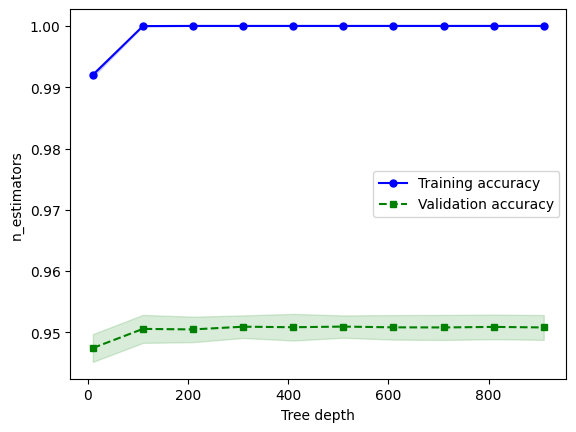

In [43]:
benchmark(RandomForestClassifier, 'n_estimators', np.arange(10, 1000, 100))

n_estimators = 100

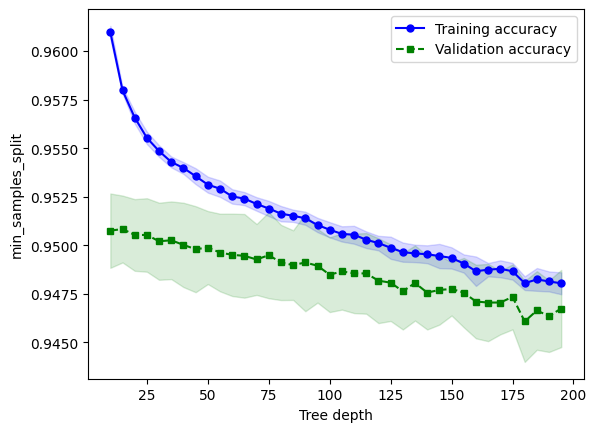

In [47]:
benchmark(RandomForestClassifier, 'min_samples_split', np.arange(10, 200, 5))

min_samples_split = 200

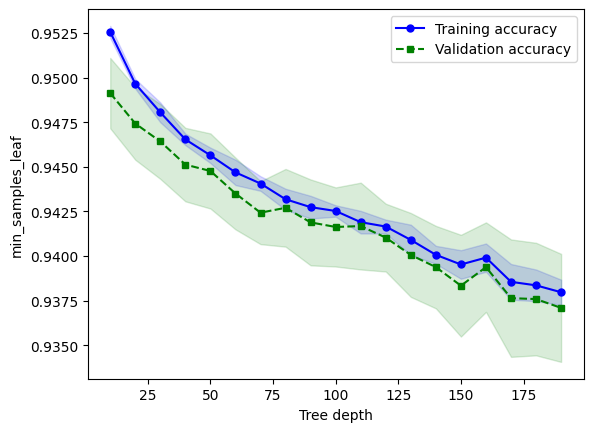

In [11]:
from sklearn.ensemble import RandomForestClassifier

benchmark(RandomForestClassifier, 'min_samples_leaf', np.arange(10, 200, 10))

min_samples_leaf = 50

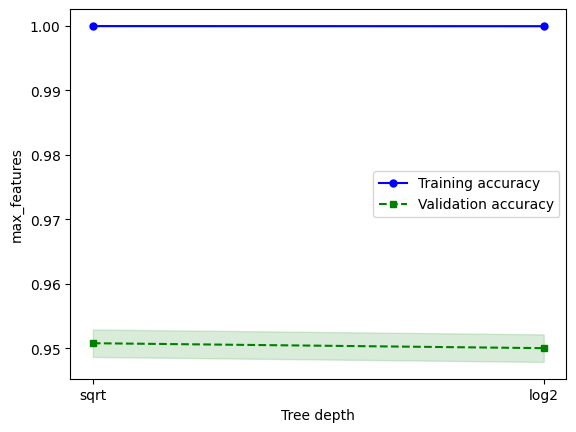

In [12]:
benchmark(RandomForestClassifier, 'max_features', ['sqrt', 'log2'])

In [13]:
cls  = RandomForestClassifier(
    max_depth=5,               # Maximum tree depth
    n_estimators=100,          # Number of trees
    min_samples_split=200,      # Minimum number of samples required to split an internal node
    min_samples_leaf=50,        # Minimum number of samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider when looking for the best split
    bootstrap=True,            # Use bootstrap samples when building trees
    random_state=42            # For reproducibility
)

In [14]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', cls)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file',
                                                   'loan_grade'])])),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=50,
                                        min_samples_split=200,
                                        random_state=42))])

In [16]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, pipe_final.predict(X_train))
test_acc = accuracy_score(y_test, pipe_final.predict(X_test))

print(f'Train accuracy: {train_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Train accuracy: 0.9393
Test accuracy: 0.9396


In [17]:
def submit(model):
    test_df = pd.read_csv("data/test.csv")
    y_pred = model.predict(test_df)
    submission = pd.DataFrame({
        'id': test_df['id'],
        'loan_status': y_pred
    })
    submission.to_csv('data/submission.csv', index=False)
    print("Predictions saved to submission.csv")
    return submission

In [19]:
submit(pipe_final)

Predictions saved to submission.csv


,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,1


# Randomized search

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

param_grid = {
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [10, 50, 100, 200],
    'model__min_samples_split': [5, 10, 15, 20],
    'model__min_samples_leaf': [5, 10, 15, 20],
    'model__max_features': ['sqrt', 'log2']
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=10,
    cv=10,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['person_age',
                                                                                'person_income',
                                                                                'person_emp_length',
                                                                                'loan_amnt',
                                                                                'loan_int_rate',
                                                                                'loan_percent_income',
                                                                                'cb_person_cred_hist_length']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_...
                                                                                'loan_grade',
                                                                                'cb_person_default_on_file',
                                                                                'loan_grade'])])),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [5, 10, 15,
                                                                    20],
                                        'model__min_samples_split': [5, 10, 15,
                                                                     20],
                                        'model__n_estimators': [10, 50, 100,
                                                                200]},
                   random_state=42, scoring='accuracy')

In [15]:
print(rs.best_score_)
print(rs.score(X_test, y_test))

0.9475232406180197
0.9488447437974252


In [18]:
submit(rs)

Predictions saved to submission.csv


,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


In [10]:
rs.best_params_

{'model__n_estimators': 50,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 5,
 'model__max_features': 'log2',
 'model__max_depth': 15}

In [21]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

hs = HalvingRandomSearchCV(
    pipe,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=42,
    n_jobs=-1
)

# hs.fit(X_train, y_train)

# Metrics

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = rs.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
confmat

array([[9980,  107],
       [ 493, 1149]])

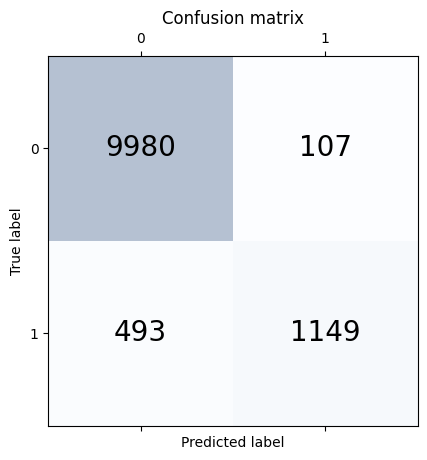

In [24]:
fig, ax = plt.subplots()
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], size=20, horizontalalignment='center', verticalalignment='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

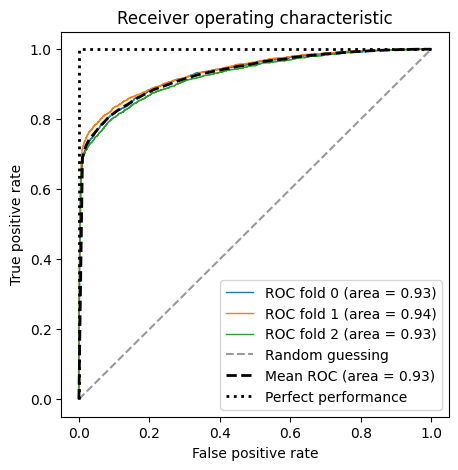

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from numpy import interp

# {'model__n_estimators': 50,
#  'model__min_samples_split': 10,
#  'model__min_samples_leaf': 5,
#  'model__max_features': 'log2',
#  'model__max_depth': 15}

pipe  = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=50,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='log2',
        max_depth=15
    ))
])

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(5, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = pipe.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()